In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
import numpy as np
import numpy as np
import torch
from pysmiles import read_smiles
import networkx as nx
import dgllife
from rdkit import Chem
import random
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import dgl
from dgl import DGLGraph
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import pandas
import csv
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import functools
#%run MoleculeGenerator2.ipynb
%run Discrim.ipynb
%run ChemEnv.ipynb
%run MolUtils.ipynb
%run Tests.ipynb



Using backend: pytorch[09:57:12] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.9.1.so: cannot open shared object file: No such file or directory

/home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630836880/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
batch = dgl.load_graphs('./graph_decomp/chunk_0')

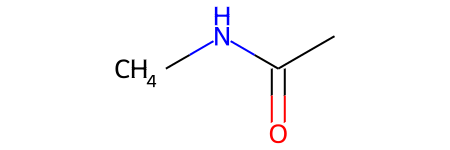

In [14]:
MolFromGraphsFULL(batch[0][10])

In [4]:
drugs = pandas.read_csv('SmallDrug.csv',error_bad_lines=False,delimiter=';')
smiles_values = drugs['Smiles'].values


/home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
len(smiles_values)

38683

In [6]:
def data_base_generator(smiles,chunk_size, path):
    '''function for generating and storing decomposition trajectories'''
    i = chunk_size 
    j=0
    while i < len(smiles):
        graphs = []
        last_action_nodes = []
        actions = []
        smiles_chunk = smiles[i-chunk_size: i]
        
        for smile in smiles_chunk:
            if mol_checker(smile,'SMILES'):
                graph = smiles_to_graph([smile])[0]
                graphs_single,last_action_nodes_single, actions_single = full_graph_decomp(graph)
                
                graphs.extend(graphs_single)
                last_action_nodes.extend(last_action_nodes_single)
                actions.extend(actions_single)
        print(torch.tensor(last_action_nodes).shape)
        print(torch.tensor(actions).shape)
        
        graph_labels = {"last_action" : torch.tensor(last_action_nodes), 
                        "actions" : torch.tensor(actions)}
        
    
        dgl.save_graphs('./graph_decomp/chunk_' + str(j),graphs, graph_labels)
        j+=1
        i+= chunk_size
        print(i)
    
    
    

In [7]:
def DataBaseGeneration(smiles,chunk_size):
    i = chunk_size
    j = 0
    atom_types = ['N','C','O','S','F','Cl','Na','P','Br','Si','B','Se','K']

    while i < len(smiles):
        state_list = []
        action_list = []
        smiles_chunk = smiles[i-chunk_size: i]
        
        for smile in smiles_chunk:
            try:
                mol = Chem.MolFromSmiles(smile)
            except:
                continue
            if all([atom.GetSymbol() in atom_types for atom in mol.GetAtoms()]) and all([bond.GetBondType() != Chem.BondType.TRIPLE for bond in mol.GetBonds()]):
                states,actions = FullMolDecomp(mol)
                state_list.extend(states)
                action_list.extend(actions)
                
                
        zipped = list(zip(state_list,action_list))
        random.shuffle(zipped)
        state_list_shuffle,action_list_shuffle = zip(*zipped)
        graph_list, last_action_node_list, last_atom_feat_list = zip(*state_list_shuffle)
        
        graph_labels = {"last_action" : torch.tensor(last_action_node_list),
                        "last_atom_feats" : torch.cat(last_atom_feat_list,dim=0),
                        "actions" : torch.tensor(action_list_shuffle)}
        #print(llen(graphen(graph_labels["last_action"],len(graph_labels["last_atom_feats"]),len(graph_labels["actions"])))
        print(type(graph_list))
        dgl.save_graphs('./graph_decomp/chunk_' + str(j),list(graph_list), graph_labels)
        j+=1
        i+= chunk_size
        print(i)
        
        
        

In [8]:
def DataBaseGenerationBIGSHUFFLE(smiles,chunk_size):
    i = 0
    j = 0
    atom_types = ['N','C','O','S','F','Cl','Na','P','Br','Si','B','Se','K']
    
    state_list = []
    action_list = []

    for smile in smiles:
        try:
            mol = Chem.MolFromSmiles(smile)
        except:
            continue
        if all([atom.GetSymbol() in atom_types for atom in mol.GetAtoms()]) and all([bond.GetBondType() != Chem.BondType.TRIPLE for bond in mol.GetBonds()]):
            states,actions = FullMolDecomp(mol)
            state_list.extend(states)
            action_list.extend(actions)
            
            
            
    zipped = list(zip(state_list,action_list))
    random.shuffle(zipped)
    state_list_shuffle,action_list_shuffle = zip(*zipped)
    graph_list, last_action_node_list, last_atom_feat_list = zip(*state_list_shuffle)

    while i < len(state_list) - chunk_size:
        _slice = slice(i,i+chunk_size)
        
        last_action_node_list_slice = last_action_node_list[_slice]
        last_atom_feat_list_slice = last_atom_feat_list[_slice]
        
        graph_list_slice = graph_list[_slice]
        
        action_list_slice = action_list_shuffle[_slice]
        
        graph_labels = {"last_action" : torch.tensor(last_action_node_list_slice),
                        "last_atom_feats" : torch.cat(last_atom_feat_list_slice,dim=0),
                        "actions" : torch.tensor(action_list_slice)}
        
        dgl.save_graphs('./graph_decomp/chunk_' + str(j),list(graph_list_slice), graph_labels)
        j+=1
        i+= chunk_size
        print(i)
        
        
        

In [19]:
def DataBaseGenerationONEFILE(smiles):
    i = 0
    j = 0
    atom_types = ['N','C','O','S','F','Cl','Na','P','Br','Si','B','Se','K']
    
    state_list = []
    action_list = []

    for i,smile in enumerate(smiles):
        if i%1000 == 0:
            print(i)
        try:
            mol = Chem.MolFromSmiles(smile)
        except:
            continue
        if all([atom.GetSymbol() in atom_types for atom in mol.GetAtoms()]) and all([bond.GetBondType() != Chem.BondType.TRIPLE for bond in mol.GetBonds()]):
            states,actions = FullMolDecomp(mol)
#             for state in states:
#                 print(state)
            state_list.extend(states)
            action_list.extend(actions)
            
            
            
#     zipped = list(zip(state_list,action_list))
#     random.shuffle(zipped)
#     state_list_shuffle,action_list_shuffle = zip(*zipped)
#     graph_list, last_action_node_list, last_atom_feat_list = zip(*state_list_shuffle)
    
#     print(torch.tensor(last_action_node_list).shape,torch.stack(last_atom_feat_list,dim=0).shape)
    graph_list, last_action_node_list, last_atom_feat_list = zip(*state_list)
    
    graph_labels = {"last_action" : torch.tensor(last_action_node_list),
                    "last_atom_feats" : torch.cat(last_atom_feat_list,dim=0),
                    "actions" : torch.tensor(action_list)}

    dgl.save_graphs('./graph_decomp/full_chunka',list(graph_list), graph_labels)

        
        
        

In [34]:
DataBaseGenerationONEFILE(smiles_values)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


In [22]:
graphs = dgl.load_graphs('./graph_decomp/full_chunka')

In [24]:
graphs, g_dict = graphs

tensor(2.) tensor(0.)


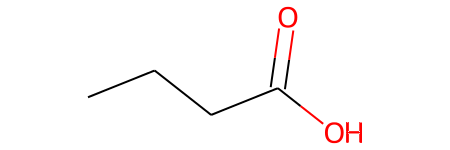

In [33]:
i = 3
print(g_dict['actions'][i], g_dict['last_action'][i])
MolFromGraphsFULL(graphs[i])

In [11]:
def FullMolDecomp(mol, return_mol = False):
    
    
    
    graph = selfLoop(mol_to_graph_full(mol))
    last_action_node = torch.zeros((1,1)).to(device)
    
    #states = [graph, last_action_node, torch.unsqueeze(graph.ndata['atomic'][-1],dim=0)]
    obs = (graph, last_action_node, torch.unsqueeze(graph.ndata['atomic'][-1],dim=0))
    states = [obs]
    actions = [torch.zeros(1)]
    mol_list = [mol]
    
    
    i = 1
    success = True
    while success:
        mol, obs, action, success = MolDecompStep(mol)
        if success:
            states.append(obs)
            actions.append(action)
            mol_list.append(mol)
    if return_mol:
        return mol_list, states, actions
    
    return states,actions
        
        
        
    

In [12]:
def MolDecompStep(mol):
    '''
    input: RDKit Mol 
    Output: (RDKit Mol, last action node, node features) 
    
    Priority:
    
    1. Remove Lone Node/Aromatic ring
    2. Disconnect Aromatic Ring
    3. Disconnect Atom
    4. Break Cycle
    '''
    mol_copy = permute_mol(mol, lambda x: x) 
    Chem.SanitizeMol(mol_copy)
    success = False
    
    if not success:
        mol, obs, action, success = remove_node(mol_copy)
    
    if not success:
        mol, obs, action, success = remove_aro_ring(mol_copy)
    
        
    if not success:
        mol, obs, action, success = remove_ring_edge(mol_copy)
        
    if not success:
        mol, obs, action, success = remove_node_edge(mol_copy)    
              
    if not success:
        mol, obs, action, success = break_cycle(mol_copy)
      
        
    if success and mol.GetNumAtoms()>1:
        return mol, obs, action, success 
    
    return None, None, None, False
    
    
    
    
    
    
    

In [13]:
def _remove_edge(mol, atom1_idx, atom2_idx,len_node_actions=16):
    if atom1_idx == mol.GetNumAtoms()-1:
        atom1_idx, atom2_idx = atom2_idx, atom1_idx
    new_mol = permuteAtomToEnd(mol,atom2_idx)
    b = new_mol.GetBondBetweenAtoms(new_mol.GetNumAtoms()-1,atom1_idx)
    bt = b.GetBondType()
    
    if bt == 'SINGLE':
        bt_int = 0
    else:
        bt_int = 1
        
    new_mol.RemoveBond(new_mol.GetNumAtoms()-1,atom1_idx)
    action =  2*atom1_idx + len_node_actions + bt_int
    
    return new_mol, action
    


In [14]:
def remove_node(mol):
    
    atom_list = ['N','C','O','S','F','Cl','Na','P','Br','Si','B','Se','K', 'Aro']    
    for atom in mol.GetAtoms():
        if atom.GetDegree() == 0:
            atom_idx = atom.GetIdx()
            atom_symbol = atom.GetSymbol() 

            action = atom_list.index(atom_symbol) + 1
            mol.RemoveAtom(atom_idx)
            
            
            try:
                Chem.SanitizeMol(mol)
                graph = mol_to_graph_full(mol)
                last_action_node = torch.zeros((1,1)).to(device)
                obs = graph, last_action_node, torch.unsqueeze(graph.ndata['atomic'][-1], dim = 0)                
                return mol, obs, action, True
            except Chem.rdchem.KekulizeException:
                return (None,None,None), -1, False 
    
    
    return None, (None,None,None), -1, False
        
        
        

In [15]:
#decide on aromatic ring ordering 
#ORDERING WILL BE OFF UNTILL DECIDING ON HOW MANY RINGS TO ALLOW
def remove_aro_ring(mol):
    aro_dict_list = [{'C': 6}, {'N': 1, 'C': 5}, {'N': 1, 'C': 4}]
    aro_list = ['Benz', 'Pyri', 'Pyrr']
    cycles = list(mol.GetRingInfo().AtomRings())
    
    for cycle in cycles:
        if all([mol.GetAtomWithIdx(atom_id).GetIsAromatic() for atom_id in cycle]) and all([mol.GetAtomWithIdx(atom_id).GetDegree() == 2 for atom_id in cycle]):
            aro_cycle = cycle
            atom_types_dict = (Counter([mol.GetAtomWithIdx(atom_id).GetSymbol() for atom_id in cycle]))
            
            try:
                aro_idx = aro_dict_list.index(atom_types_dict)
            except:
                continue
            aro_idx_name = aro_list[aro_idx]
    
            for atom_idx in sorted(aro_cycle, reverse = True):
                mol.RemoveAtom(atom_idx)
            action = 1 + 13 + aro_idx
            
            if mol.GetNumAtoms() == 0:
                    return None, (None,None,None), -1, False 
            try:
                Chem.SanitizeMol(mol)
                graph = mol_to_graph_full(mol)
                last_action_node = torch.zeros((1,1)).to(device)
                obs = graph, last_action_node, torch.unsqueeze(graph.ndata['atomic'][-1], dim = 0)   
                
                return mol, obs, action, True
            except Chem.rdchem.KekulizeException:
                return None, (None,None,None), -1, False 
        
    
    return None, (None,None,None), -1, False 
            
                
    

In [16]:
#edge_type 
def remove_node_edge(mol):    
    for atom in mol.GetAtoms():
        if atom.GetDegree() == 1:
            atom_idx = atom.GetIdx()
            b = list(atom.GetBonds())[0]
            other_atom_idx = b.GetOtherAtom(atom).GetIdx()
            new_mol, action = _remove_edge(mol,other_atom_idx,atom_idx)
            
            try:
                Chem.SanitizeMol(new_mol)
                graph = mol_to_graph_full(new_mol)
                last_action_node = torch.ones((1,1)).to(device)
                obs = graph, last_action_node, torch.unsqueeze(graph.ndata['atomic'][-1], dim = 0)                
                return new_mol, obs, action, True
            except Chem.rdchem.KekulizeException:
                return None, (None,None,None), -1, False 
            
                
    
    return None, (None,None,None), -1, False

In [17]:
def remove_ring_edge(mol):
    cycles = list(mol.GetRingInfo().AtomRings())
    for cycle in cycles:
        degrees = [mol.GetAtomWithIdx(cycle_idx).GetDegree() for cycle_idx in cycle] 
        is_aromatic = [mol.GetAtomWithIdx(cycle_idx).GetIsAromatic() for cycle_idx in cycle] 
        if sum(degrees) == (len(degrees) * 2) + 1 and all(is_aromatic):
            idx_in_cycle = degrees.index(3)
            
            atom_idx = cycle[idx_in_cycle]
            atom = mol.GetAtomWithIdx(atom_idx)
            b_list = list(atom.GetBonds())
            
            
            for b in b_list:
                bt = b.GetBondType()
                if bt != Chem.rdchem.BondType.AROMATIC:
                    break
            else:
                continue
                
                
            other_atom_idx = b.GetOtherAtom(atom).GetIdx()
            new_mol, action = _remove_edge(mol,atom_idx,other_atom_idx)
            
            
            
            try:
                Chem.SanitizeMol(new_mol)
                graph = mol_to_graph_full(new_mol)
                last_action_node = torch.ones((1,1)).to(device)
                obs = graph, last_action_node, torch.unsqueeze(graph.ndata['atomic'][-1], dim = 0)                
                return new_mol, obs, action, True
            except Chem.rdchem.KekulizeException:
                return None, (None,None,None), -1, False 
                
        
    
    return None, (None,None,None), -1, False 
            
            
            
            

In [18]:
def break_cycle(mol):
        for atom_i in range(mol.GetNumAtoms()):
            if mol.GetAtomWithIdx(atom_i).GetIsAromatic():
                continue
            for atom_j in range(atom_i+1, mol.GetNumAtoms()):
                if mol.GetAtomWithIdx(atom_j).GetIsAromatic():
                    continue
                bond = mol.GetBondBetweenAtoms(atom_i,atom_j)
                if bond == None:
                    continue
                
                bond_type_int = bondTypeInt(bond.GetBondType())
                mol_copy = permute_mol(mol,lambda x: x)
                mol_copy.RemoveBond(atom_i,atom_j)
                if not nx.is_connected(mol_to_graph(mol_copy).to_networkx().to_undirected()):
                    continue
                new_mol, action = _remove_edge(mol,atom_i,atom_j)
                graph = mol_to_graph_full(new_mol)
                last_action_node = torch.ones((1,1)).to(device)
                obs = graph, last_action_node, torch.unsqueeze(graph.ndata['atomic'][-1], dim = 0)
                Chem.SanitizeMol(new_mol)
                return new_mol, obs, action, True
        else:
            return None, (None,None,None), -1, False 
            
                    
                    

In [16]:
graph_l, dic = dgl.load_graphs('./graph_decomp/full_chunk0')

DGLError: [17:29:24] /opt/dgl/third_party/dmlc-core/src/io/local_filesys.cc:43: Check failed: !std::fseek(fp_, static_cast<long>(pos), SEEK_SET): 
Stack trace:
  [bt] (0) /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x4f) [0x7fb41d61aeef]
  [bt] (1) /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/libdgl.so(dmlc::io::FileStream::Seek(unsigned long)+0x73) [0x7fb41e905d73]
  [bt] (2) /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/libdgl.so(dgl::serialize::LoadHeteroGraphs(std::string const&, std::vector<unsigned long, std::allocator<unsigned long> >)+0x3d2) [0x7fb41deabb92]
  [bt] (3) /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/libdgl.so(+0xe39e6f) [0x7fb41dea4e6f]
  [bt] (4) /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/libdgl.so(DGLFuncCall+0x48) [0x7fb41ddb1bb8]
  [bt] (5) /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/_ffi/_cy3/core.cpython-37m-x86_64-linux-gnu.so(+0x17663) [0x7fb588027663]
  [bt] (6) /home/theo/anaconda3/envs/prawn/lib/python3.7/site-packages/dgl/_ffi/_cy3/core.cpython-37m-x86_64-linux-gnu.so(+0x1798b) [0x7fb58802798b]
  [bt] (7) /home/theo/anaconda3/envs/prawn/bin/python(_PyObject_FastCallKeywords+0x15c) [0x563c65e5188c]
  [bt] (8) /home/theo/anaconda3/envs/prawn/bin/python(_PyEval_EvalFrameDefault+0x47e5) [0x563c65e99545]



In [18]:
#check value 23

In [19]:
test_mol = Chem.MolFromSmiles(smiles_values[19])
moldecomp = FullMolDecomp(test_mol,return_mol=True)
test_mol

NameError: name 'smiles_values' is not defined

14


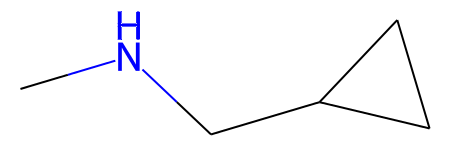

In [215]:
i = 5
print(moldecomp[2][i])
moldecomp[0][i]

25


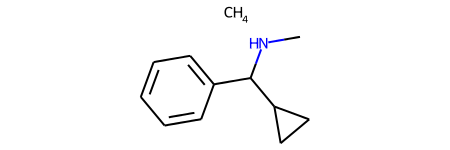

In [196]:
dmol,obs,action,val = MolDecompStep(dmol)
print(action)
dmol


tensor(25.)


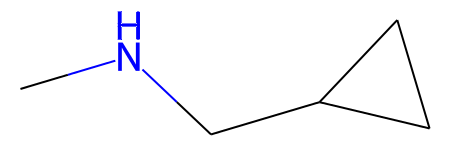

In [192]:
i = 4
print(dic['actions'][i])
mol_x = MolFromGraphsFULL(graph_l[i])
mol_x

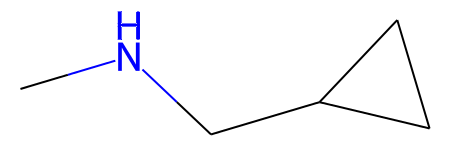

In [149]:
cvt.Clear
cvt.AssignMol(mol_x)
cvt.Step(int(dic['actions'][i]+4))
cvt.GetMol()

In [129]:
n_mol, obs, action, value = remove_ring_edge(mol)
print(action)

33


33


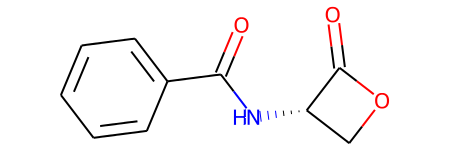

In [130]:
cvt.Clear
cvt.AssignMol(n_mol)
print(action)
cvt.Step(action)
cvt.GetMol()

In [260]:
wgraph, wdict = dgl.load_graphs('./graph_decomp/full_chunkx0')

tensor(14.)


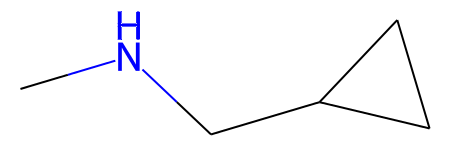

In [262]:
i = 1
print(wdict['actions'][i])
MolFromGraphsFULL(wgraph[i])

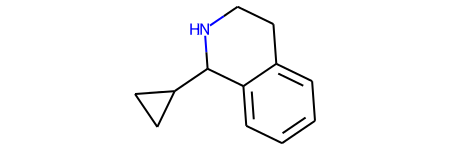

In [228]:
test_mol = Chem.MolFromSmiles(smiles_values[19])
moldecomp = FullMolDecomp(test_mol,return_mol=True)
test_mol

14


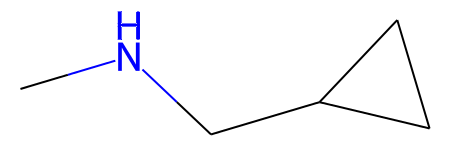

In [268]:
j = 5

print(int(moldecomp[2][j]))
moldecomp[0][j]